In [5]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter, find_peaks

In [6]:
def zero_pad(Y):
    mx, my = Y.shape
    padded_x = ((mx + 7) // 8) * 8
    padded_y = ((my + 7) // 8) * 8
    img = np.zeros((padded_x, padded_y), dtype=np.uint8)
    img[:mx, :my] = Y
    
    return img

def DCT(img):
    w, h = img.shape
    num_blocks = (w // 8) * (h // 8)
    dct_output = np.zeros((8, 8, num_blocks), dtype=float) 

    for ci, (i, j) in enumerate((x, y) for x in range(0, w, 8) for y in range(0, h, 8)):
        dct_output[:, :, ci] = cv2.dct(img[i:i+8, j:j+8].astype(np.float32)) 

    return dct_output


def hist(DC, N=2000, show=False):
    hcount, bin_edges = np.histogram(DC, bins=N, density=True)
    if show:
        plt.figure(figsize=(10, 6))
        sns.histplot(x=bin_edges[:-1], weights=hcount, bins=N, kde=True, stat="density")
        plt.title("DC Coefficient Histogram")
        plt.xlabel("DC Coefficient Value")
        plt.ylabel("Density")
        plt.show()
    return hcount, bin_edges

def FFT(hcount):
  hcount -= np.mean(hcount)
  x = np.fft.fft(hcount.astype(float))
  x = abs(np.fft.fftshift(x))
  x = savgol_filter(x, 20, 3)
  return x


def quality(x, N=2000):
    ref = np.mean(x)
    ref += 0.05
    peaks, _ = find_peaks(x, height=ref, distance=15)

    if len(peaks) <= 1:
        Q = 100
    else:
        distances = np.diff(peaks)
        avg_dist = np.bincount(distances).argmax()
        if avg_dist > 400:
            Q=90 
        elif avg_dist > 40:
            Q = 50  
        else:
            Q = 10  

    print("Most Frequent Distance:", avg_dist if len(peaks) > 1 else "N/A")
    return Q, peaks



Most Frequent Distance: 41
Quality of the image: 50


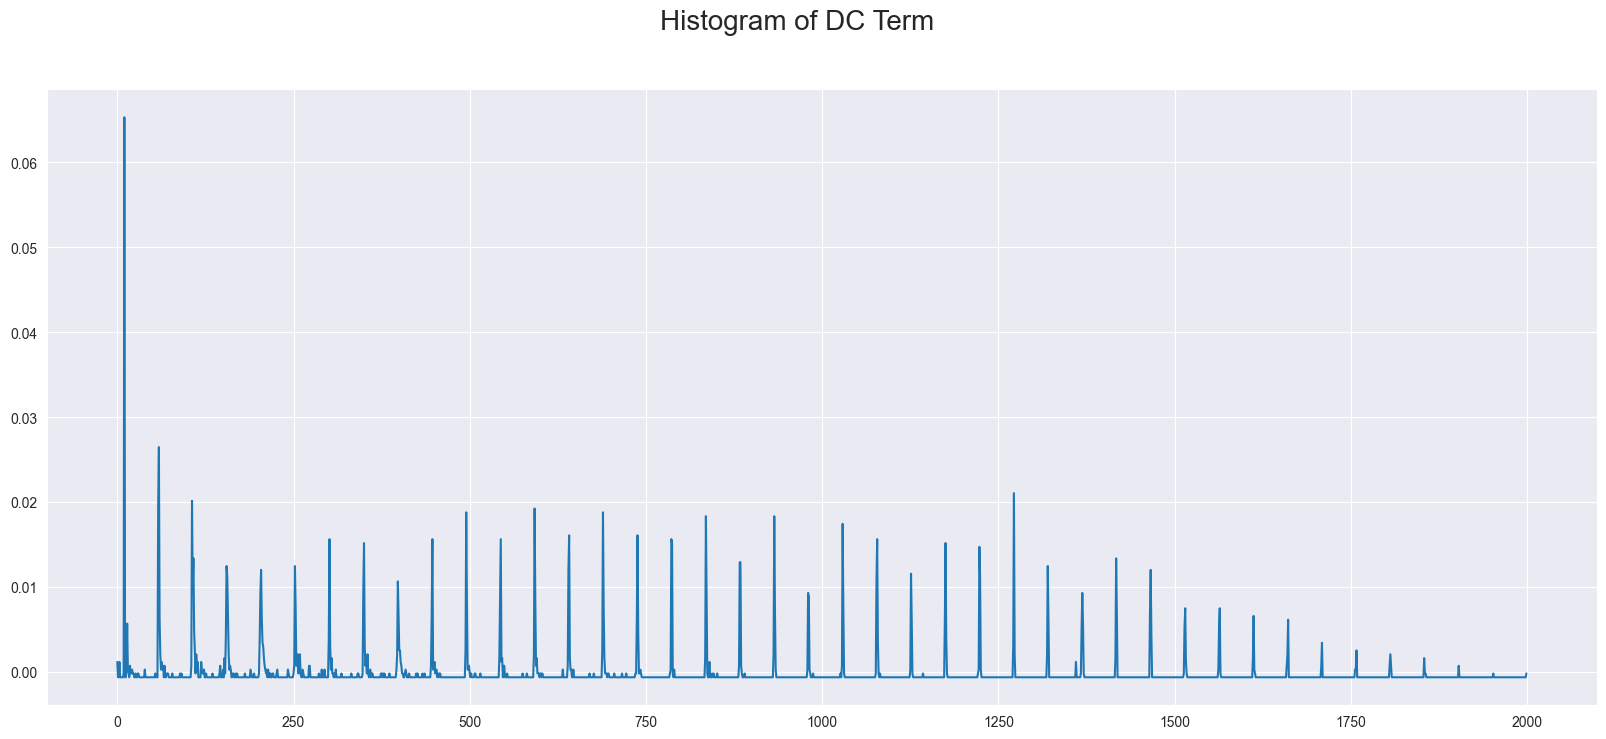

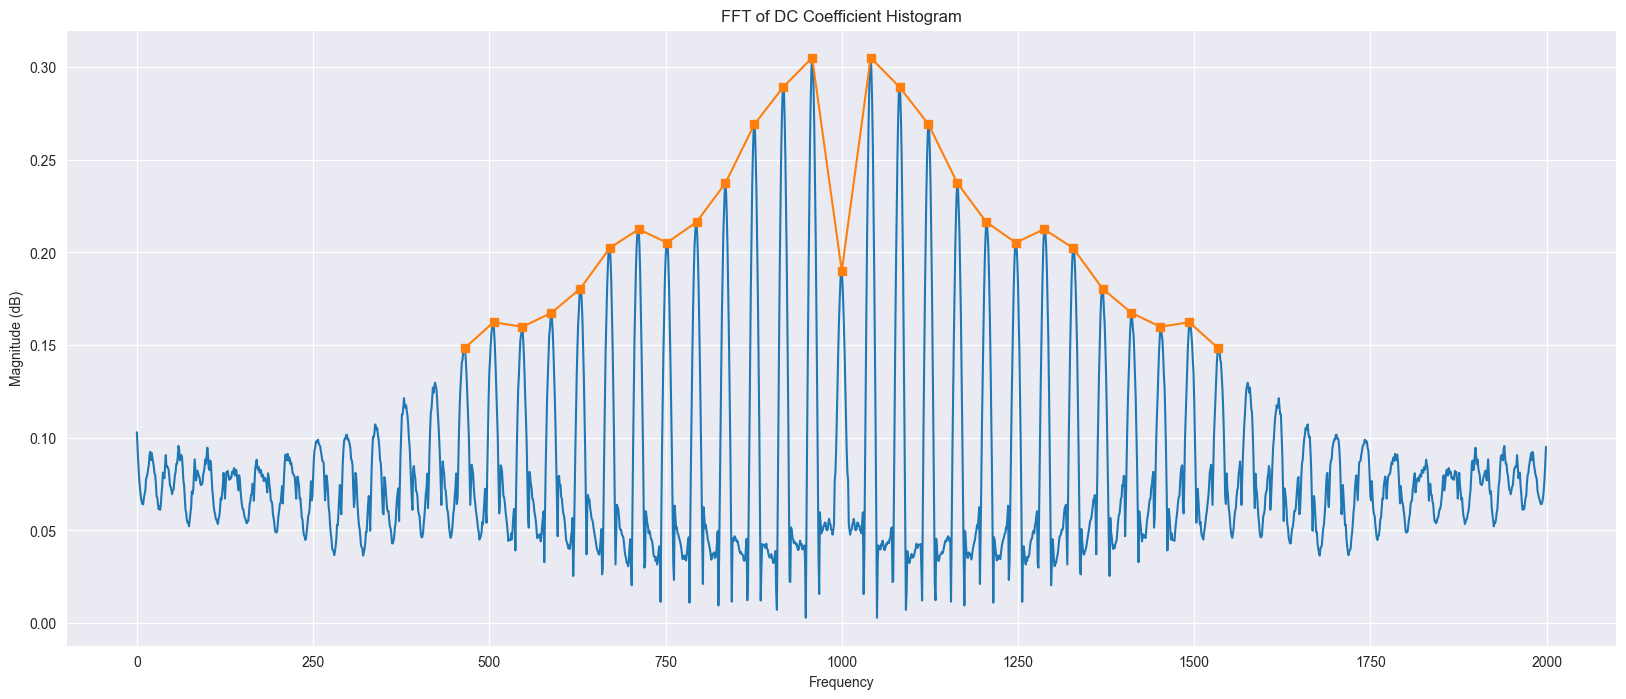

In [7]:
img = Image.open("temp_png.png")

img = img.convert('YCbCr')
img = zero_pad(np.array(img)[:,:,0])
img = img.astype(np.float64)
dct = DCT(img)[0,0,:]
hcount, bin_edges = hist(dct)
fft = FFT(hcount)
image_quality, max_list = quality(fft)

print(f"Quality of the image: {image_quality}")

fig = plt.figure(figsize=(20,8))
plt.plot(hcount)
fig.suptitle("Histogram of DC Term",fontsize=20)


plt.figure(figsize=(20, 8))
plt.plot(fft)
plt.plot(max_list, fft[max_list], marker='s')
plt.title("FFT of DC Coefficient Histogram")
plt.xlabel("Frequency")
plt.ylabel("Magnitude (dB)")
plt.show()